
## Billing Server Throttle Comparison

The heaviest read load that the billing server will place on meta is the monthly stage job.  The heaviest write load occurs when the billing server promotes the staged charges.

For this analysis, those two jobs were run twice--once with and once without throttling.  Periodically, we collected `Innodb_rows_read` and `Innodb_rows_inserted`--which were used to derive the reads-per-seconds and the writes-per-second.  The results are plotted below.

In [95]:
import json
from collections import namedtuple
from collections import OrderedDict


def get_data(filename):
    with open(filename, 'r') as f:
        return json.loads(f.read())
    
# moments look like: [timestamp, reads_per_second, inserts_per_second, charges_per_second]
   
Sample = namedtuple("Sample", "rps, ips, cps")

Run = namedtuple("Run", "color, job, algorithm samples")
data = [ 
        Run('#db1d37', "monthly", "unthrottled", get_data('data/monthly_before.json')),
        Run('#49b82d', "monthly", "throttled (10ms per 50)", get_data('data/monthly_after.json')),
        Run('#db1d37', "promote (monthly)", "unthrottled", get_data('data/monthly_promote_before.json')),
        Run('#49b82d', "promote (monthly)", "throttled 10/50ms per 50", get_data('data/monthly_promote_after.json')),
       ]
        
processed_runs = []
sample_times = set()

for run in data:
    
    # how long was this run?
    sec = lambda x: x[0]
    t_low = min(map(sec, run[3]))
    t_high = max(map(sec, run[3]))
    
    # organize samples by time-in-run (not clock time)
    samples = OrderedDict()
    for idx, raw in enumerate(run.samples):
        moment = raw[0] - t_low;
        samples[moment] = Sample(raw[1], raw[2], raw[3])
        sample_times.add(moment)
        
    processed_runs.append(Run(run.color,
                              run.job,
                              run.algorithm,
                              samples))

unthrottled 
   median: 18828.0 
      max: 315850 
 duration: 0:34:7 

throttled (10ms per 50) 
   median: 15195.5 
      max: 286154 
 duration: 2:13:33 



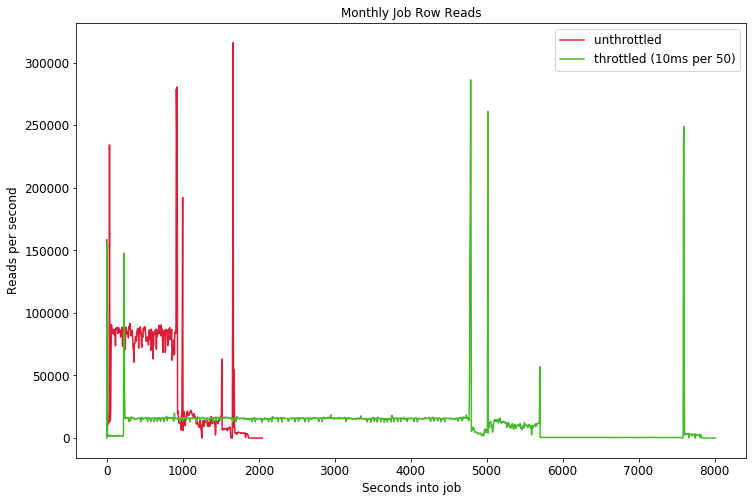

In [99]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
#plt.xscale('log')
#plt.yscale('log')
plt.title('Monthly Job Row Reads')

labels = []
for idx, run in enumerate(processed_runs):
    if run.job == "monthly":
        labels.append(run.algorithm)
        
        rps_ps = [v.rps for v in run.samples.values()]
        plt.plot(run.samples.keys(), rps_ps, color=run.color)

        median = np.median(rps_ps)

        m, s = divmod(max(run.samples.keys()), 60)
        h, m = divmod(m, 60)

        duration = max(run.samples.keys())
        print(run.algorithm,"\n   median:", median,
              "\n      max:", max(rps_ps),
              "\n duration: {}:{}:{}".format(h,m,s),
              "\n")
    
plt.legend(labels)    
plt.xlabel("Seconds into job")
plt.ylabel("Reads per second")
plt.show()


The throttle parameters used above (0 extra threads, 10ms per 50 merchants) are the same values that we intend to use in production.  The plot above shows that the throttle is effective at distributing the read-load across a configurable duration.

unthrottled 
   median: 970.0 
      max: 1044 
 duration: 0:3:49 

throttled 10/50ms per 50 
   median: 48.0 
      max: 125 
 duration: 1:10:19 



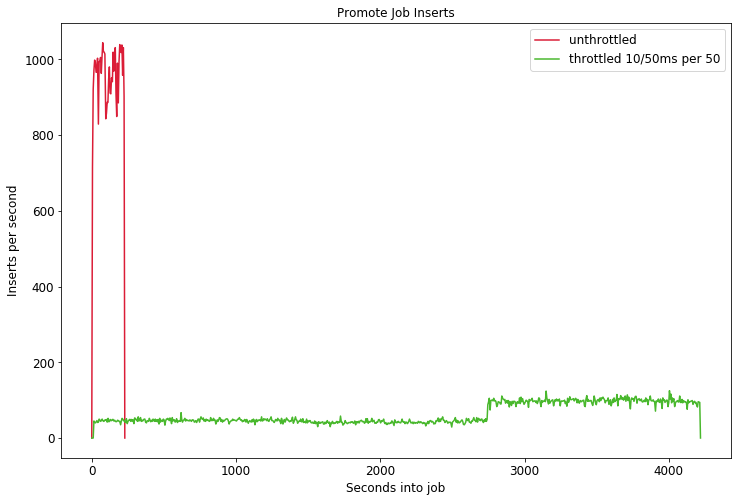

In [100]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
#plt.xscale('log')
#plt.yscale('log')
plt.title('Promote Job Inserts')

labels = []
for idx, run in enumerate(processed_runs):
    if run.job == "promote (monthly)":
        labels.append(run.algorithm)
        
        ips_ps = [v.ips for v in run.samples.values()]
        plt.plot(run.samples.keys(), ips_ps, color=run.color)

        median = np.median(ips_ps)

        m, s = divmod(max(run.samples.keys()), 60)
        h, m = divmod(m, 60)

        duration = max(run.samples.keys())
        print(run.algorithm,"\n   median:", median,
              "\n      max:", max(ips_ps),
              "\n duration: {}:{}:{}".format(h,m,s),
              "\n")
    
plt.legend(labels)    
plt.xlabel("Seconds into job")
plt.ylabel("Inserts per second")
plt.show()


In the scenario above, we didn't want to wait for the promote to complete, so we opened the throttle from 10ms to 50ms.  This configuration change appears as the step in the green curve.   The plot above shows that the billing server's throttle is also effective at distributing the write load in a consistent way.